# Project Proposal: Prediction of Heart Disease Using a Classification Model

Authors: Janie Holzmann, Riley McNair, Stephanie Ta, and Hayden Wai.

## Introduction

Heart disease is the second leading cause of death in Canada, and occurs due to a build up of plaque in a person’s arteries (via [Government of Canada](https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html)). It can lead to a heart attack, heart failure, or death. Many factors can increase a person’s likelihood of getting a heart disease diagnosis, and with this project, we want to answer the question: **Can a person’s age, sex, resting blood pressure, cholesterol, fasting blood sugar, and susceptibility to exercise-induced anginas accurately predict if they will get diagnosed with heart disease?** We will be using a dataset from the Cleveland Clinic Foundation from 1988, which includes these various attributes for 303 patients, and whether or not they were diagnosed with heart disease.

## Methods and Results

In [46]:
# load packages
library(tidyverse) # needed for many functions used for data analysis, such as read_csv(), select(), etc.
library(repr) # needed to resize plots
library(tidymodels) # needed to split data into training and testing data and to perform classification
library(cowplot) # needed to put plots side-by-side

The dataset can be obtained from UC Irvine's Machine Learning Repository: https://archive.ics.uci.edu/dataset/45/heart+disease via a zip file.

In [2]:
# read in dataset from web
url <- "https://archive.ics.uci.edu/static/public/45/heart+disease.zip"
download.file(url, "cleveland_data.zip")
unzip("cleveland_data.zip")
cleveland_original <- read_csv("processed.cleveland.data",
                               col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                        "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"),
                               show_col_types = FALSE)

# preview first 5 rows of the dataframe
head(cleveland_original, 5)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


We cleaned the dataset to only contain information relevant to our analysis and converted a column's values to make more sense. Specifically, the dataset's description indicates that values 1, 2, 3, and 4 in the num column means that heart disease is present but does not indicate what differences in these values mean. So we converted num into a binary column (0 = no heart disease; 1 = presence of heart disease).

In [3]:
# select for columns we'll use
cleveland <- select(cleveland_original, age, sex, trestbps, chol, fbs, exang, num)

# convert num column to binary factor (0 = no heart disease; 1 = presence of heart disease)
cleveland <- cleveland |>
    mutate(num = ifelse(num != 0, 1, 0)) |>
    mutate(num = as_factor(num))

# preview first 5 rows of new dataframe
head(cleveland, 5)

age,sex,trestbps,chol,fbs,exang,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,145,233,1,0,0
67,1,160,286,0,1,1
67,1,120,229,0,1,1
37,1,130,250,0,0,0
41,0,130,204,0,0,0


We then split our cleaned data into training and testing data, then performed exploratory data analysis on the training data.

In [4]:
#set seed to make our data analysis reproducible
set.seed(10)

cleveland_split <- initial_split(cleveland, prop = 0.75, strata = num)
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

To gain insight into our training data, the following data tables were made to see the number of observations in each class of sex, fasting blood sugar level, and if an individual gets exercise induced angina (chest pain).

In [5]:
# table for number of observations in each class of sex: (1 = male; 0 = female)
cleveland_train_sex <- cleveland_training |>
    group_by(sex) |>
    summarize(amount_of_individuals = n())

cleveland_train_sex

# table for number of observations in each class of fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
cleveland_train_fbs <- cleveland_training |>
    group_by(fbs) |>
    summarize(amount_of_individuals = n())

cleveland_train_fbs

# table for number of observations in each class of exang: exercise induced angina (1 = yes; 0 = no)
cleveland_train_exang <- cleveland_training |>
    group_by(exang) |>
    summarize(amount_of_individuals = n())

cleveland_train_exang

sex,amount_of_individuals
<dbl>,<int>
0,72
1,155


fbs,amount_of_individuals
<dbl>,<int>
0,190
1,37


exang,amount_of_individuals
<dbl>,<int>
0,157
1,70


We also found the means of our planned predictor variables:

In [6]:
cleveland_train_means <- cleveland_training |>
    select(-num) |>
    map_df(mean)

cleveland_train_means

age,sex,trestbps,chol,fbs,exang
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
54.00441,0.6828194,131.4581,243.3084,0.1629956,0.30837


Additionally, we visualized the distributions of each numerical/non-binary predictor variables (age, resting blood pressure, and cholesterol level) in the following histograms:

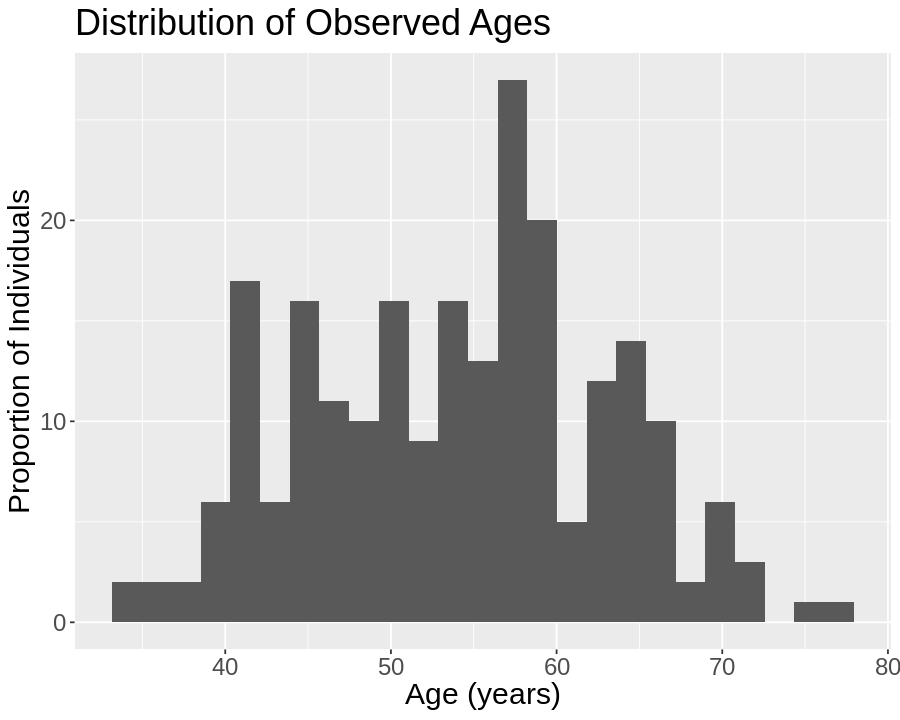

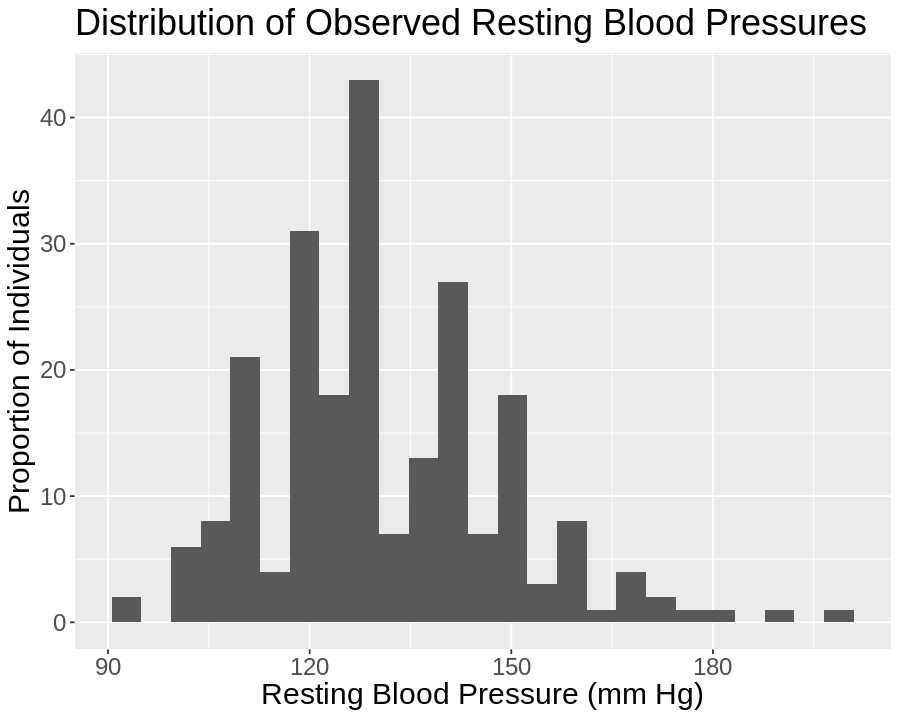

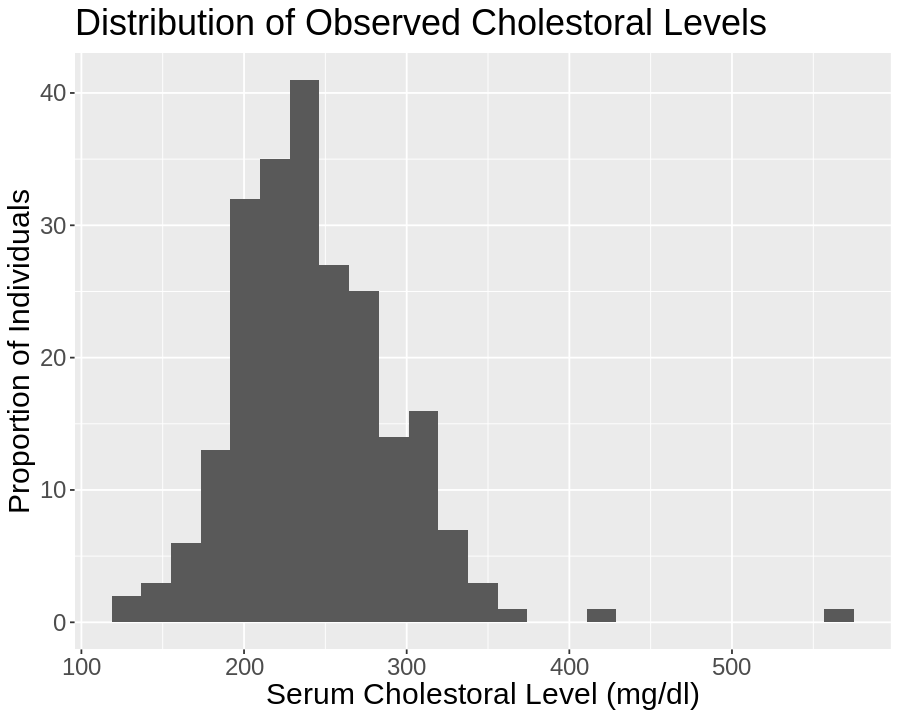

In [7]:
# set size of the plots
options(repr.plot.height = 6, repr.plot.width = 7.5)

# distribution of age
age_dist <- cleveland_training |>
    ggplot(aes(x = age)) +
    geom_histogram(bins = 25) +
    labs(x = "Age (years)", y = "Proportion of Individuals") +
    ggtitle("Distribution of Observed Ages") +
    theme(text = element_text(size = 18))
age_dist

# distribution of trestbps: resting blood pressure
trestbps_dist <- cleveland_training |>
    ggplot(aes(x = trestbps)) +
    geom_histogram(bins = 25) +
    labs(x = "Resting Blood Pressure (mm Hg)", y = "Proportion of Individuals") +
    ggtitle("Distribution of Observed Resting Blood Pressures") +
    theme(text = element_text(size = 18))
trestbps_dist

# distribution of chol: serum cholestoral
chol_dist <- cleveland_training |>
    ggplot(aes(x = chol)) +
    geom_histogram(bins = 25) +
    labs(x = "Serum Cholestoral Level (mg/dl)", y = "Proportion of Individuals") +
    ggtitle("Distribution of Observed Cholestoral Levels") +
    theme(text = element_text(size = 18))
chol_dist

In [8]:
# main data analysis
# make model spec for knn classification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# make recipe and standardize data
cleveland_recipe <- recipe(num ~ ., data = cleveland_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

# split training data into 5 parts for cross-validation
cleveland_vfold <- vfold_cv(cleveland_training, v = 5, strata = num)

# make workflow
cleveland_workflow <- workflow() |>
    add_recipe(cleveland_recipe) |>
    add_model(knn_spec)

# make tibble with a range of k values
grid_vals <- tibble(neighbors = 1:15)

# tune workflow to test all k values, resample using cross validation data set, collect stats from model
knn_results <- cleveland_workflow |>
    tune_grid(resamples = cleveland_vfold, grid = grid_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

# get k value that yields the highest accuracy estimate
k_max_accuracy <- knn_results |>
    arrange(desc(mean)) |>
    slice(1) |>
    pull(neighbors)

[1] 13

In [22]:
# make new model spec for the best k
best_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_max_accuracy) |>
    set_engine("kknn") |>
    set_mode("classification")

# retrain classifier
best_fit <- workflow() |>
    add_recipe(cleveland_recipe) |>
    add_model(best_knn_spec) |>
    fit(data = cleveland_training)

# get predictions on test data
knn_predictions <- best_fit |>
    predict(cleveland_testing) |>
    bind_cols(cleveland_testing)

# get estimate of accuracy of classifier on testing data
knn_accuracy <- knn_predictions |>
    metrics(truth = num, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    pull(.estimate)

knn_accuracy
knn_predictions

[1] 0.75

.pred_class,age,sex,trestbps,chol,fbs,exang,num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,63,1,145,233,1,0,0
1,67,1,160,286,0,1,1
0,37,1,130,250,0,0,0
0,62,0,140,268,0,0,1
1,57,0,120,354,0,1,0
0,48,1,110,229,0,0,1
0,58,1,132,224,0,0,1
1,60,1,130,206,0,1,1
0,58,0,120,340,0,0,0


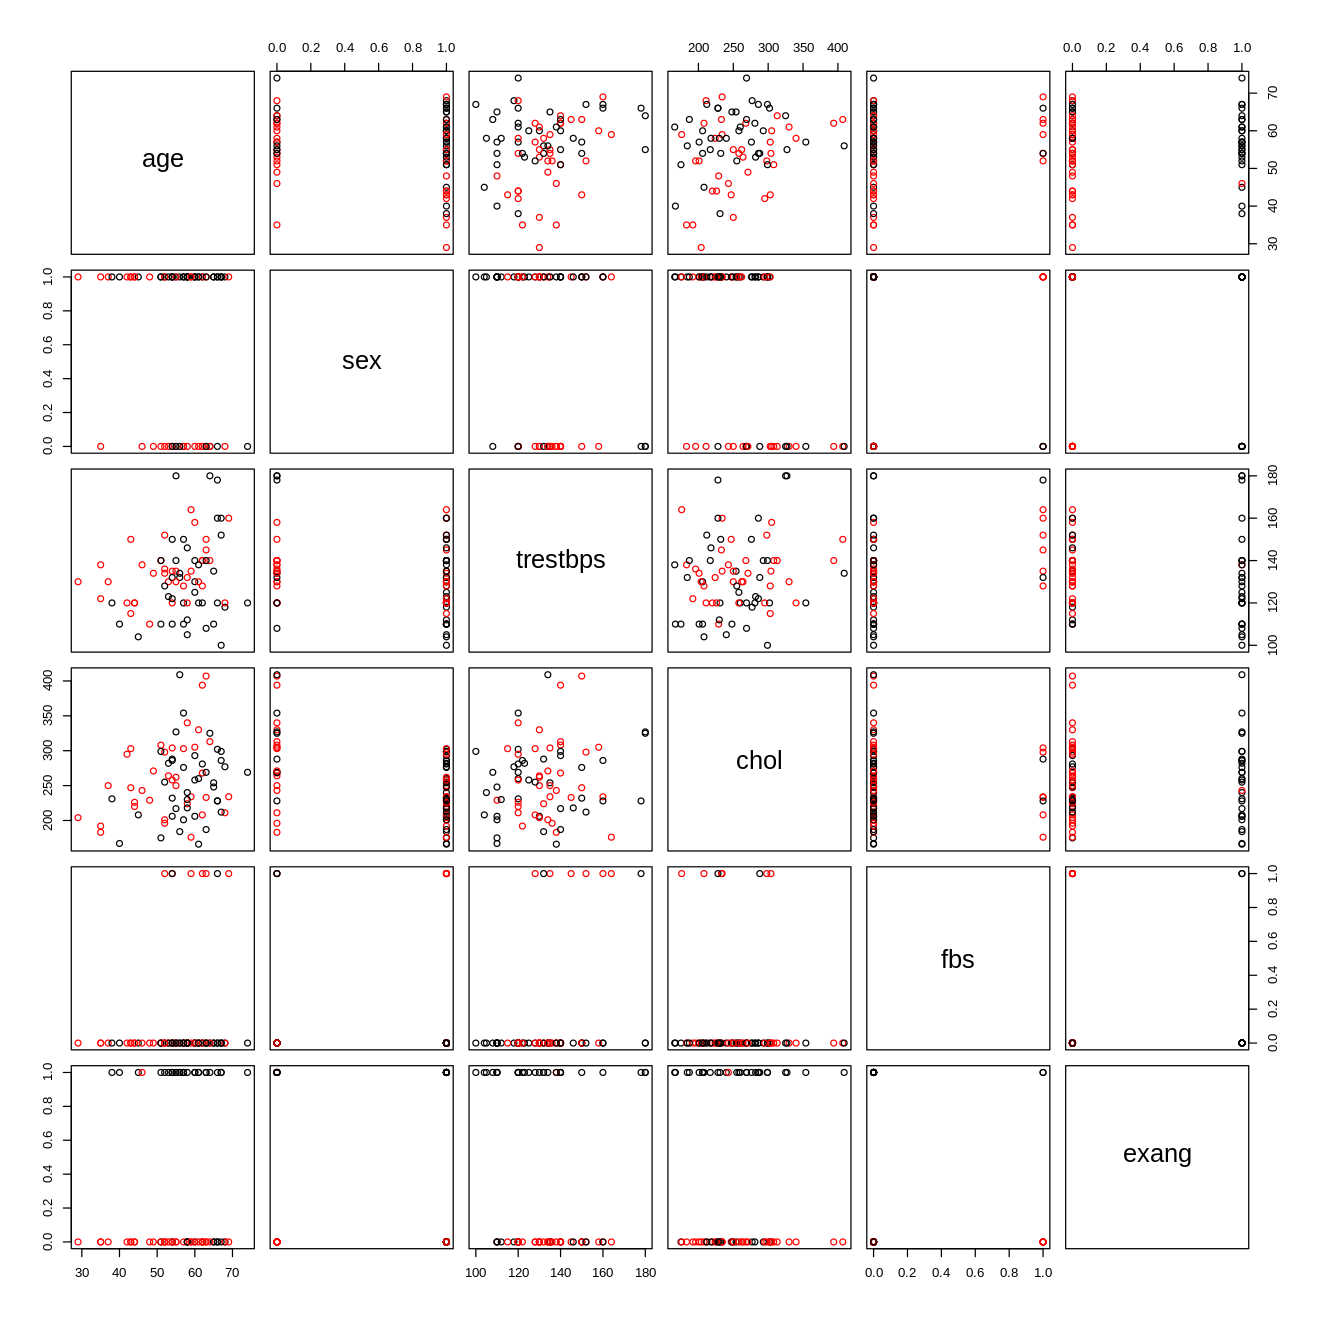

In [24]:
#rough visualization, will not use this
options(repr.plot.width = 11, repr.plot.height = 11)
select(cleveland_testing, -num) |> pairs(col = c("red", "black")[knn_predictions$.pred_class])#lower.panel = panel.smooth)

#4 colours, sex+classification, box plot (4); fbs and exang bar graph
#age plots, fbs and exang plots like ^

In [74]:
#rough visualizations of age vs. quantitative variables
age_vs_trestbps_sex <- knn_predictions |>
    mutate(sex = as_factor(sex)) |>
    ggplot(aes(x = trestbps, y = age, colour = .pred_class)) +
        stat_ellipse() +
        geom_point(aes(shape = sex), size = 3) +
        theme(text = element_text(size = 20))

age_vs_chol_sex <- knn_predictions |>
    mutate(sex = as_factor(sex)) |>
    ggplot(aes(x = chol, y = age, colour = .pred_class)) +
        stat_ellipse() +
        geom_point(aes(shape = sex), size = 3) +
        theme(text = element_text(size = 20))

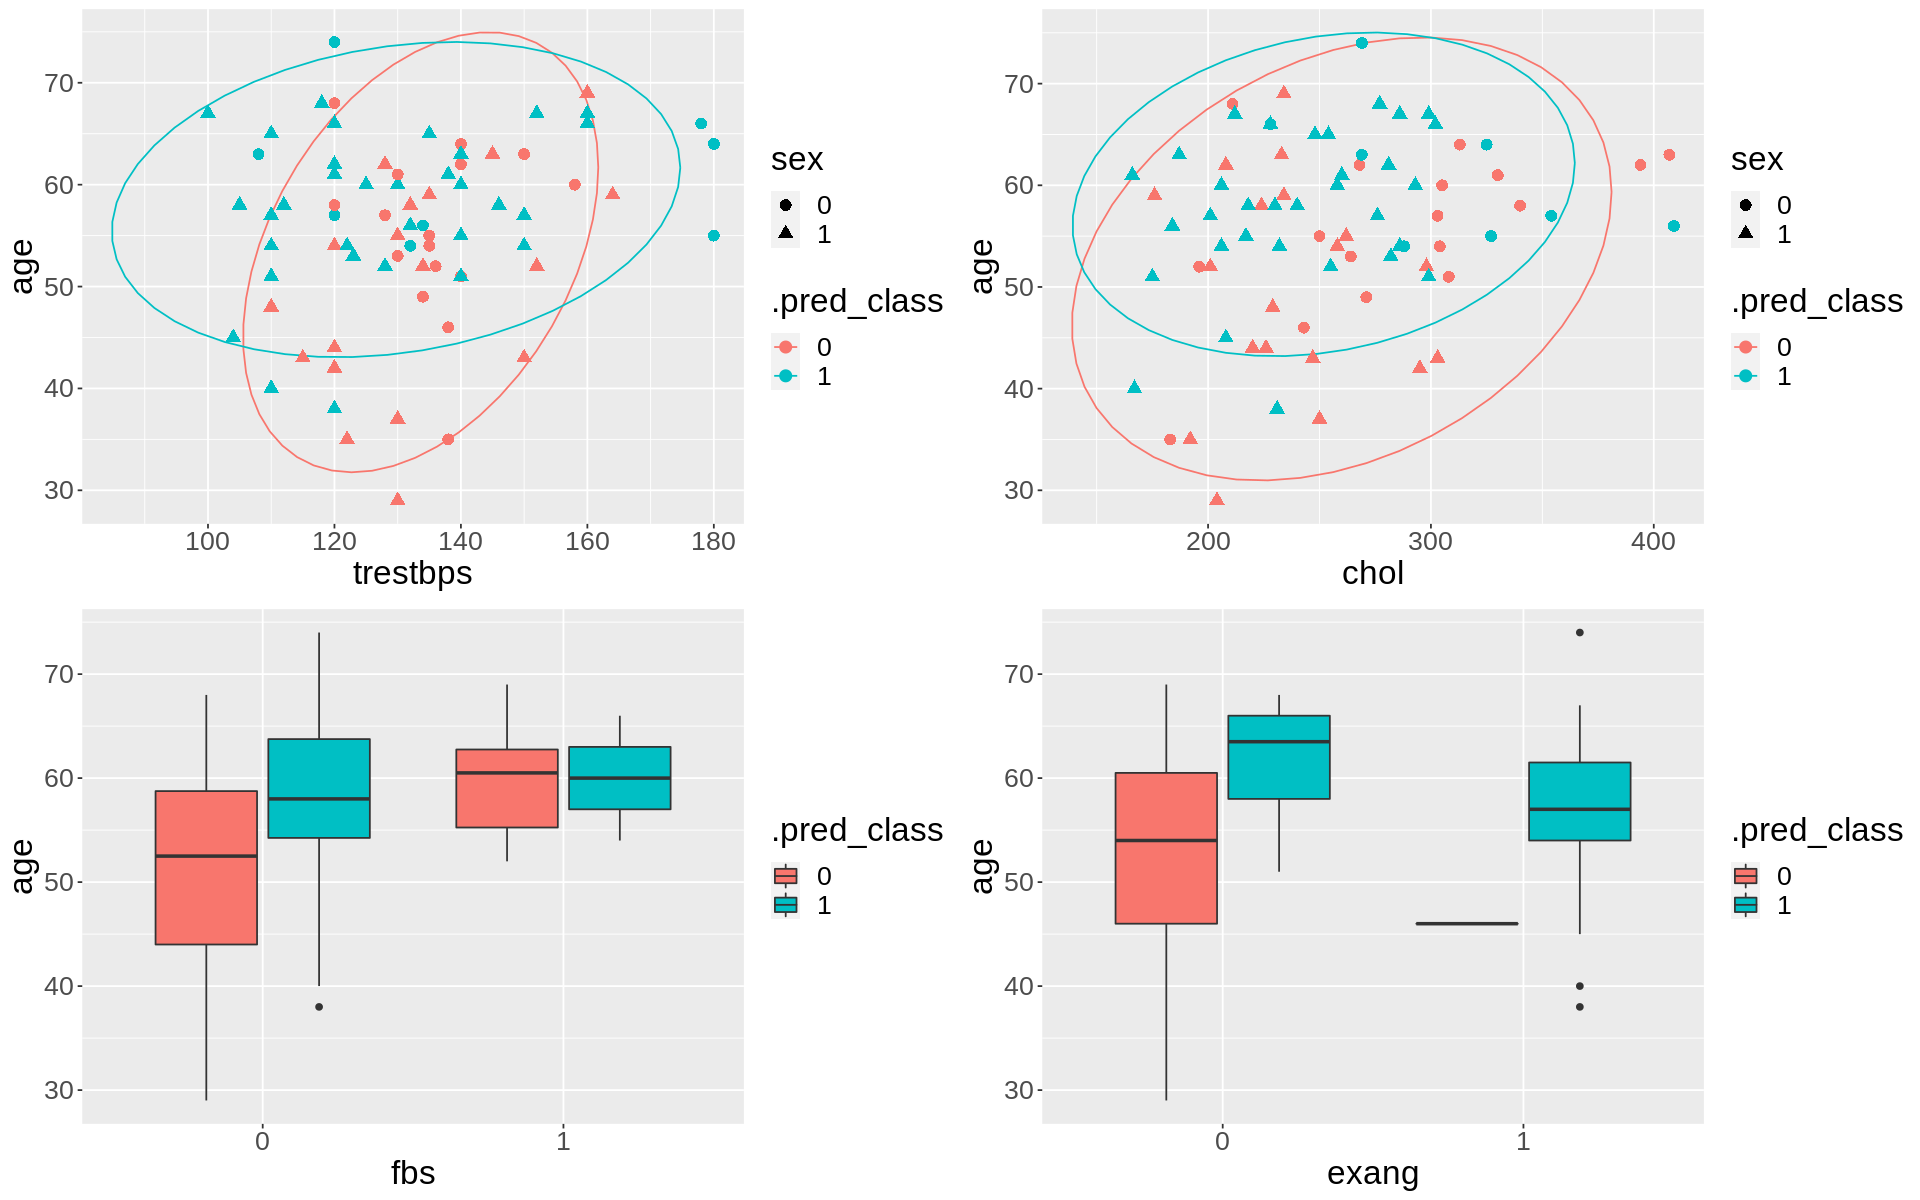

In [75]:
#rough visualizations of age vs. categorical variables
age_vs_fbs <- knn_predictions |>
    mutate(fbs = as_factor(fbs)) |>
    ggplot(aes(x = fbs, y = age, fill = .pred_class)) +
        geom_boxplot() +
        theme(text = element_text(size = 20))

age_vs_exang <- knn_predictions |>
    mutate(exang = as_factor(exang)) |>
    ggplot(aes(x = exang, y = age, fill = .pred_class)) +
        geom_boxplot() +
        theme(text = element_text(size = 20))

options(repr.plot.width = 16, repr.plot.height = 10)
plot_grid(age_vs_trestbps_sex, age_vs_chol_sex, age_vs_fbs, age_vs_exang)

## Discussion

## References